## Importing libraries

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 30.2 MB/s 


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 171 kB/s 
     |████████████████████████████████| 182 kB 70.8 MB/s 
     |████████████████████████████████| 7.6 MB 66.4 MB/s 


In [ ]:
import os
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K
from tensorflow.keras import mixed_precision
import tensorflow_addons as tfa
import dill
import matplotlib.pyplot as plt
import transformers
from transformers import AutoTokenizer, AutoConfig,TFAutoModel
import json
import matplotlib.pyplot as plt

## Notebook Parameters

In [ ]:
data_exists = False
MODEL_NAME = 'roberta-base'
TRAIN = True # True to train and evaluate the model
RESET = True # True to retrain the same model without using committed model files, generates tokens data
INPUT = 'nbme-tensorflow-bert-baseline' # The notebooks name

## Training Parameters

In [ ]:
TRAIN_SPLIT = 0.8
BATCH_SIZE = 12
EPOCHS = 20
SEQUENCE_LENGTH = 512
SEED = 999

## Notebook Configuration

In [ ]:
# Prevents Data Sharding
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA

# Sets output size for plots
plt.rcParams["figure.figsize"] = (15, 10)

In [ ]:
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
try: # detect TPUs

    tpu  = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection

    tf.config.experimental_connect_to_cluster(tpu)

    tf.tpu.experimental.initialize_tpu_system(tpu)

    strategy = tf.distribute.TPUStrategy(tpu)

    print('Using TPU')



except ValueError: # detect GPUs

    tpu = None

    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines

    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU

    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines



print("Number of accelerators: ", strategy.num_replicas_in_sync)



AUTO = tf.data.experimental.AUTOTUNE

REPLICAS = strategy.num_replicas_in_sync

print(f'REPLICAS: {REPLICAS}')

Number of accelerators:  1
REPLICAS: 1


# Data

In [ ]:
# Input competition data path
#data_input_path = '../input/nbme-score-clinical-patient-notes'

# Loads the data using Pandas
features = pd.read_csv("/content/features.csv", engine = 'python')
patient_notes = pd.read_csv('/content/patient_notes.csv')
test = pd.read_csv('/content/test.csv')
train = pd.read_csv('/content/train.csv')
sample_submission= pd.read_csv('/content/sample_submission.csv')

In [ ]:
train.head()

,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258']


In [ ]:
train.describe(include='all')

,id,case_num,pn_num,feature_num,annotation,location
count,14300,14300.000000,14300.000000,14300.000000,14300,14300
unique,14300,NaN,NaN,NaN,5201,7534
top,00016_000,NaN,NaN,NaN,[],[]
freq,1,NaN,NaN,NaN,4399,4399
mean,NaN,4.594406,48223.952448,466.440559,NaN,NaN
std,NaN,2.919144,29608.965339,292.315326,NaN,NaN
min,NaN,0.000000,16.000000,0.000000,NaN,NaN
25%,NaN,2.000000,21317.000000,209.000000,NaN,NaN
50%,NaN,5.000000,51040.000000,502.000000,NaN,NaN
75%,NaN,7.000000,73834.000000,708.000000,NaN,NaN


In [ ]:
patient_notes.head()

,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student heal..."
1,1,0,17 yo male with recurrent palpitations for the...
2,2,0,Dillon Cleveland is a 17 y.o. male patient wit...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \...
4,4,0,17yo male with no pmh here for evaluation of p...


* Each *pn_history* is a note written by the medical students taking the test,
* *pn_num* ids each of these *pn_history* notes.

In [ ]:
patient_notes.describe(include='all')

,pn_num,case_num,pn_history
count,42146.000000,42146.000000,42146
unique,NaN,NaN,42146
top,NaN,NaN,"17-year-old male, has come to the student heal..."
freq,NaN,NaN,1
mean,52440.256347,4.943862,NaN
std,25165.865233,2.529762,NaN
min,0.000000,0.000000,NaN
25%,35618.250000,3.000000,NaN
50%,50911.500000,5.000000,NaN
75%,73037.750000,7.000000,NaN


In [ ]:
features.head()

,feature_num,case_num,feature_text
0,0,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,1,0,Family-history-of-thyroid-disorder
2,2,0,Chest-pressure
3,3,0,Intermittent-symptoms
4,4,0,Lightheaded


In [ ]:
features.describe(include='all')

,feature_num,case_num,feature_text
count,143.000000,143.000000,143
unique,NaN,NaN,131
top,NaN,NaN,Female
freq,NaN,NaN,7
mean,466.440559,4.594406,NaN
std,293.332543,2.929303,NaN
min,0.000000,0.000000,NaN
25%,209.500000,2.000000,NaN
50%,502.000000,5.000000,NaN
75%,707.500000,7.000000,NaN


In [ ]:
sample_submission

,id,location
0,00016_000,0 100
1,00016_001,NaN
2,00016_002,200 250;300 400
3,00016_003,NaN
4,00016_004,75 110


In [ ]:
test

,id,case_num,pn_num,feature_num
0,00016_000,0,16,0
1,00016_001,0,16,1
2,00016_002,0,16,2
3,00016_003,0,16,3
4,00016_004,0,16,4


In [ ]:
test.head()

,id,case_num,pn_num,feature_num
0,00016_000,0,16,0
1,00016_001,0,16,1
2,00016_002,0,16,2
3,00016_003,0,16,3
4,00016_004,0,16,4


In [ ]:
# Merges the patient_notes & features onto the train & test data
train = train.merge(patient_notes,on=['case_num', 'pn_num']).merge(features,on=['case_num', 'feature_num'])
test = test.merge(patient_notes,on=['case_num', 'pn_num']).merge(features,on=['case_num', 'feature_num'])

In [ ]:
train.head(10)

,id,case_num,pn_num,feature_num,annotation,location,pn_history,feature_text
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724'],HPI: 17yo M presents with palpitations. Patien...,Family-history-of-MI-OR-Family-history-of-myoc...
1,00041_000,0,41,0,[],[],17 Y/O M CAME TO THE CLINIC C/O HEART POUNDING...,Family-history-of-MI-OR-Family-history-of-myoc...
2,00046_000,0,46,0,['father: heart attack'],['824 844'],Mr. Cleveland is a 17yo M who was consented by...,Family-history-of-MI-OR-Family-history-of-myoc...
3,00082_000,0,82,0,['Father MI'],['622 631'],17 yo M w/ no cardiac or arrhythmia PMH presen...,Family-history-of-MI-OR-Family-history-of-myoc...
4,00100_000,0,100,0,['Dad-MI'],['735 741'],HPI: Dillon Cleveland is an otherwise healthy ...,Family-history-of-MI-OR-Family-history-of-myoc...
5,00161_000,0,161,0,['father had acute MI'],['601 620'],"17 y/o M , Dillon Cleveland comes with c/o of ...",Family-history-of-MI-OR-Family-history-of-myoc...
6,00188_000,0,188,0,['father heart attach'],['716 735'],17 yo M college student comes to the clinic du...,Family-history-of-MI-OR-Family-history-of-myoc...
7,00211_000,0,211,0,['Father MI'],['682 688;695 697'],HPI: Patient is a 17 yo m with a c/o of palpit...,Family-history-of-MI-OR-Family-history-of-myoc...
8,00224_000,0,224,0,['dad had recent MI'],['483 500'],"Pt is a 17 y/o M w/ episodic feeling of ""heart...",Family-history-of-MI-OR-Family-history-of-myoc...
9,00225_000,0,225,0,['dad had heart attack'],['735 755'],17 y/o previously healthy male here with heart...,Family-history-of-MI-OR-Family-history-of-myoc...


In [ ]:
train.describe()

,case_num,pn_num,feature_num
count,14300.000000,14300.000000,14300.000000
mean,4.594406,48223.952448,466.440559
std,2.919144,29608.965339,292.315326
min,0.000000,16.000000,0.000000
25%,2.000000,21317.000000,209.000000
50%,5.000000,51040.000000,502.000000
75%,7.000000,73834.000000,708.000000
max,9.000000,95333.000000,916.000000


In [ ]:
pd.DataFrame(train['feature_num'])

,feature_num
0,0
1,0
2,0
3,0
4,0
...,...
14295,916
14296,916
14297,916
14298,916


In [ ]:
train['feature_num'].value_counts()

0      100
611    100
605    100
606    100
607    100
      ... 
305    100
306    100
307    100
308    100
916    100
Name: feature_num, Length: 143, dtype: int64

In [ ]:
EMPTY =  'EMPTY'
CLASSES = features.feature_num.unique().tolist()

if data_exists:
    # If data exsists, loads the LabelEncoder from disk
    label_encoder = dill.load(open('label_encoder.dill','rb'))
else:
    # Else, generates & fits a new LabelEncoder
    label_encoder = LabelEncoder()
    label_encoder.fit(CLASSES)
    dill.dump(label_encoder,open('/label_encoder.dill','wb'))
    
# Transforms the train & test target data
train['TARGET']= label_encoder.transform(train['feature_num'])
test['TARGET']= label_encoder.transform(test['feature_num'])
N_CLASSES = len(label_encoder.classes_)+1
EMPTY_IDX = 143 #label_encoder.transform([EMPTY,]) [0]

In [ ]:
train.head()

,id,case_num,pn_num,feature_num,annotation,location,pn_history,feature_text,TARGET
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724'],HPI: 17yo M presents with palpitations. Patien...,Family-history-of-MI-OR-Family-history-of-myoc...,0
1,00041_000,0,41,0,[],[],17 Y/O M CAME TO THE CLINIC C/O HEART POUNDING...,Family-history-of-MI-OR-Family-history-of-myoc...,0
2,00046_000,0,46,0,['father: heart attack'],['824 844'],Mr. Cleveland is a 17yo M who was consented by...,Family-history-of-MI-OR-Family-history-of-myoc...,0
3,00082_000,0,82,0,['Father MI'],['622 631'],17 yo M w/ no cardiac or arrhythmia PMH presen...,Family-history-of-MI-OR-Family-history-of-myoc...,0
4,00100_000,0,100,0,['Dad-MI'],['735 741'],HPI: Dillon Cleveland is an otherwise healthy ...,Family-history-of-MI-OR-Family-history-of-myoc...,0


# Features Tokenizer

In [ ]:
data_exists = False

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME,normalization=True)
tokenizer.save_pretrained('/content/my_tokenizer/')

('/content/my_tokenizer/tokenizer_config.json',
 '/content/my_tokenizer/special_tokens_map.json',
 '/content/my_tokenizer/vocab.json',
 '/content/my_tokenizer/merges.txt',
 '/content/my_tokenizer/added_tokens.json',
 '/content/my_tokenizer/tokenizer.json')

In [ ]:
#Function to decode the locations
def decode_location(locations):

    for x in ["[", "]", "'"]:
        locations = locations.replace(x,'')
    locations = locations.replace(',', ';')
    locations = locations.split(";")
    res = []
    for location in locations:
        if location:
            x, y = location.split()
            res.append((int(x), int(y)))
    return sorted(res, key=lambda x:x[0])
    

In [ ]:
if data_exists:
    # Loads data if it already exists on disk
    sequences = np.load(open('sequences.npy','rb'))
    masks = np.load(open('masks.npy','rb'))
    labels = np.load(open('labels.npy','rb'))
else:
    # Initialize the lists
    sequences, labels, masks = [], [], []
    # Groups dataframe by 'pn_num' and iterates over each object
    for g1 in tqdm(train.groupby('pn_num')):
        # Get the grouped dataframe
        gdf = g1[1]
        # Get whole history note text for each patient
        pn_history  = gdf.iloc[0].pn_history

        # Apply the tokenizer on the patient history text
        tokens = tokenizer.encode_plus(
            pn_history,
            max_length=SEQUENCE_LENGTH,
            padding='max_length',
            truncation=True,
            return_offsets_mapping=True)
        # Build the sequence as the tokens input ids according to the sequence lenght
        sequence = tokens['input_ids']
        attention_mask = tokens['attention_mask']
        # Initialize the empty labels
        label = np.array([EMPTY_IDX for _ in range(SEQUENCE_LENGTH)])

        # BUILDS THE TARGET ARRAY
        # Getting the tokens
        offsets = tokens['offset_mapping']
        label_empty = True
        for index, row in gdf.iterrows():
            TARGET = row.TARGET
            # Setting the targets onto the empty labels
            for i, (w_start, w_end) in enumerate(offsets):
                for start,end in decode_location(row.location):
                    if w_start < w_end and (w_start >= start) and (end >= w_end):
                        label[i] = TARGET
                        label_empty = False
                    if w_start >= w_end:
                        break
        # Appending embeddings
        if not label_empty:
            sequences.append(sequence)
            masks.append(attention_mask)
            labels.append(label)
        
    # Formats the data
    sequences = np.array(sequences).astype(np.int32)
    masks = np.array(masks).astype(np.uint8)
    labels = np.array(tf.keras.utils.to_categorical(labels,N_CLASSES)).astype(np.uint8)

    # Saves the data to disk
    np.save(open('/sequences.npy','wb'), sequences)
    np.save(open('/masks.npy','wb'), masks)
    np.save(open('/labels.npy','wb'), labels)

  0%|          | 0/1000 [00:00<?, ?it/s]

Let's observe what is actually happening during the *tokenization*.
* *Prints the last pn_history:*

In [ ]:
pn_history

'Stephanie madden is a 20 year old woman complaining of headache. Pain began yesterday morning and has been getting worse. Dull constant ache bilaterally, worse with walking, bending over, no alleviating factors. Did not respond to ibuprofen, Tylenol, or sleep. Complains of photobia, but not phonophobia, no aura. Subjective fever today. Neck stiffness. Nausea and vomiting. No dizzyness or lightheadedness, no weakness, no sick contacts.\r\nROS: otherwise negative\r\nPMH: none\r\nPSH: none\r\nHosp: none\r\nMed: Birth control pill\r\nAllergies: none\r\nSoc: works at sporting good store, lives with roomate, no tobacoo, etoh 2-3 drinks on weekends, marijuna 3-4 joints a week, sexually active and uses condoms'

* *Prints the last sequence:*

In [ ]:
np.array(sequence)

array([    0, 25093,  4134,   324,   475, 23004,    16,    10,   291,
          76,   793,   693, 13689,     9, 19344,     4, 23689,   880,
        2350,   662,     8,    34,    57,   562,  3007,     4, 38776,
        5891,  4285,   700,   741, 45931,     6,  3007,    19,  3051,
           6, 33842,    81,     6,   117, 32216, 16158,  2433,     4,
        6553,    45,  2519,     7, 34154,   658,  1001, 22132,     6,
         255,  4360,   225,  1168,     6,    50,  3581,     4, 20722,
        5069,     9, 17190, 33693,     6,    53,    45, 43676, 24938,
           6,   117, 34705,     4, 36994,  2088, 11696,   452,     4,
       33224, 37760,     4,   234, 17498,   102,     8, 23600,     4,
         440, 24719,   219,  1825,    50,  1109, 19279,  1825,     6,
         117,  8269,     6,   117,  4736,  9872,     4, 50121, 50118,
         500,  3196,    35,  3680,  2430, 50121, 50118,  5683,   725,
          35,  4146, 50121, 50118,  3888,   725,    35,  4146, 50121,
       50118,   725,

In [ ]:
np.array(attention_mask)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
label

array([143, 143, 143, 143, 143, 143, 143, 143, 127, 127, 127, 143, 143,
       143, 143, 143, 143, 143, 128, 143, 143, 143, 143, 143, 143, 143,
       143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143,
       143, 143, 143, 143, 143, 143, 126, 126, 126, 126, 126, 126, 126,
       126, 143, 126, 126, 126, 126, 143, 143, 143, 143, 143, 143, 143,
       140, 140, 143, 143, 143, 143, 143, 143, 143, 143, 143, 142, 142,
       142, 143, 143, 131, 131, 143, 134, 134, 134, 143, 132, 143, 143,
       143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 141, 141,
       141, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143,
       143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143,
       143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143,
       143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 136,
       136, 136, 136, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143,
       143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 14

##Model Training


In [ ]:
# Builds the TensorFlow dataset with the embeddings arrays
train_dataset = tf.data.Dataset.from_tensor_slices(
        ((sequences, masks), labels))

## Validation

In [ ]:
#We keep 80% of the data for training and 20% for validation.
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
sequences.shape

(1000, 512)

In [ ]:
samples = sequences.shape[0]
train_dataset, val_dataset, test_df = get_dataset_partitions_tf(
    train_dataset,
    train_split=TRAIN_SPLIT,
    val_split=0.2,
    test_split=0,
    ds_size=samples)

train_dataset, val_dataset

(<TakeDataset element_spec=((TensorSpec(shape=(512,), dtype=tf.int32, name=None), TensorSpec(shape=(512,), dtype=tf.uint8, name=None)), TensorSpec(shape=(512, 144), dtype=tf.uint8, name=None))>,
 <TakeDataset element_spec=((TensorSpec(shape=(512,), dtype=tf.int32, name=None), TensorSpec(shape=(512,), dtype=tf.uint8, name=None)), TensorSpec(shape=(512, 144), dtype=tf.uint8, name=None))>)

In [ ]:
# Creates repeating generators with options and the set batch sizer with the datasets
train_dataset = train_dataset.repeat().batch(BATCH_SIZE).with_options(options)
val_dataset = val_dataset.repeat().batch(BATCH_SIZE).with_options(options)

train_dataset, val_dataset

(<_OptionsDataset element_spec=((TensorSpec(shape=(None, 512), dtype=tf.int32, name=None), TensorSpec(shape=(None, 512), dtype=tf.uint8, name=None)), TensorSpec(shape=(None, 512, 144), dtype=tf.uint8, name=None))>,
 <_OptionsDataset element_spec=((TensorSpec(shape=(None, 512), dtype=tf.int32, name=None), TensorSpec(shape=(None, 512), dtype=tf.uint8, name=None)), TensorSpec(shape=(None, 512, 144), dtype=tf.uint8, name=None))>)

In [ ]:
steps_per_epoch = (samples * TRAIN_SPLIT) // BATCH_SIZE
validation_steps = (samples * (1 - TRAIN_SPLIT)) // BATCH_SIZE

steps_per_epoch, validation_steps

(66.0, 16.0)

## Callbacks

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    mode='min',
    patience=3)

In [ ]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    '/content/model.h5',
    monitor="f1_score",
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode="max",
    save_freq="epoch",
    options=None,
    initial_value_threshold=None)

In [ ]:
callbacks = [early_stopping, model_checkpoint]

In [ ]:
# Loads/Saves pre-trained model configuration
data_exists = False
if data_exists:
    # If data exsists, loads the config from disk
    config = AutoConfig.from_pretrained('my_tokenizer/config.json')
else:
    # Else, downloads & initializes the config from the cloud
    config = AutoConfig.from_pretrained(MODEL_NAME)
    config.save_pretrained('/content/my_tokenizer/')

In [ ]:
config

RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [ ]:
def build_model(data_exists, config):
    
    # Creates input layers
    tokens = tf.keras.layers.Input(shape=(SEQUENCE_LENGTH,), name = 'tokens', dtype=tf.int32)
    attention = tf.keras.layers.Input(shape=(SEQUENCE_LENGTH,), name = 'attention', dtype=tf.int32)
    
    if data_exists:
        # Initializes the AutoConfig Model from disk
        backbone = TFAutoModel.from_config(config)
    else:
        # Initializes the AutoConfig Model from the cloud
        backbone = TFAutoModel.from_pretrained(MODEL_NAME, config=config)
    
    # Output layers
    out = backbone(tokens, attention_mask=attention)[0]
    out = tf.keras.layers.Dropout(0.2)(out)
    # Sets the output activation to softmax
    out = tf.keras.layers.Dense(N_CLASSES, activation='softmax')(out)
    
    # Generates the model structure
    model = tf.keras.Model([tokens, attention], out)
    
    # Compiles the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss=tf.keras.losses.categorical_crossentropy,
        metrics=[tfa.metrics.F1Score(num_classes=N_CLASSES, average='micro')])
    
    return model

In [ ]:
def fit_model(model, train_ds, val_ds, steps_per_epoch, validation_steps, callbacks, epochs=10):
    
    # Fits the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        callbacks=callbacks,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps)

    return model, history

In [ ]:
#Build and Fits the model
%%time
if TRAIN:
    with strategy.scope():
        
        # Builds the model
        model = build_model(data_exists, config)
        # Fits the model
        model, history = fit_model(
            model,
            train_dataset,
            val_dataset,
            steps_per_epoch,
            validation_steps,
            callbacks,
            epochs=EPOCHS)

    # The model weights are saved thanks to the checkpoint callback

Downloading:   0%|          | 0.00/657M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/20


66/66 [==============================] - 132s 2s/step - loss: 0.9779 - f1_score: 0.8903 - val_loss: 0.5896 - val_f1_score: 0.9145
Epoch 2/20
66/66 [==============================] - 110s 2s/step - loss: 0.6084 - f1_score: 0.9125 - val_loss: 0.5439 - val_f1_score: 0.9128
Epoch 3/20
66/66 [==============================] - 110s 2s/step - loss: 0.5302 - f1_score: 0.9141 - val_loss: 0.4341 - val_f1_score: 0.9191
Epoch 4/20
66/66 [==============================] - 110s 2s/step - loss: 0.4363 - f1_score: 0.9182 - val_loss: 0.3345 - val_f1_score: 0.9275
Epoch 5/20
66/66 [==============================] - 110s 2s/step - loss: 0.3446 - f1_score: 0.9258 - val_loss: 0.2619 - val_f1_score: 0.9386
Epoch 6/20
66/66 [==============================] - 110s 2s/step - loss: 0.2851 - f1_score: 0.9331 - val_loss: 0.2032 - val_f1_score: 0.9479
Epoch 7/20
66/66 [==============================] - 110s 2s/step - loss: 0.2355 - f1_score: 0.9405 - val_loss: 0.1605 - val_f1_score: 0.9560
Epoch 8/20
66/66 [======

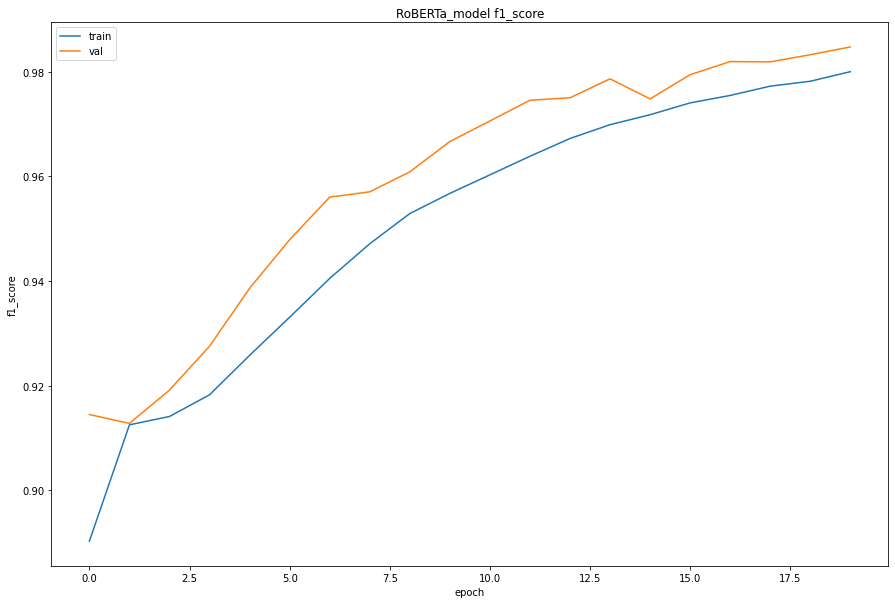

In [ ]:
#Plotiing model F-1 accuracy
if TRAIN:
    # Summarizes history for accuracy
    plt.plot(history.history['f1_score'])
    plt.plot(history.history['val_f1_score'])
    plt.title('RoBERTa_model f1_score')
    plt.ylabel('f1_score')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

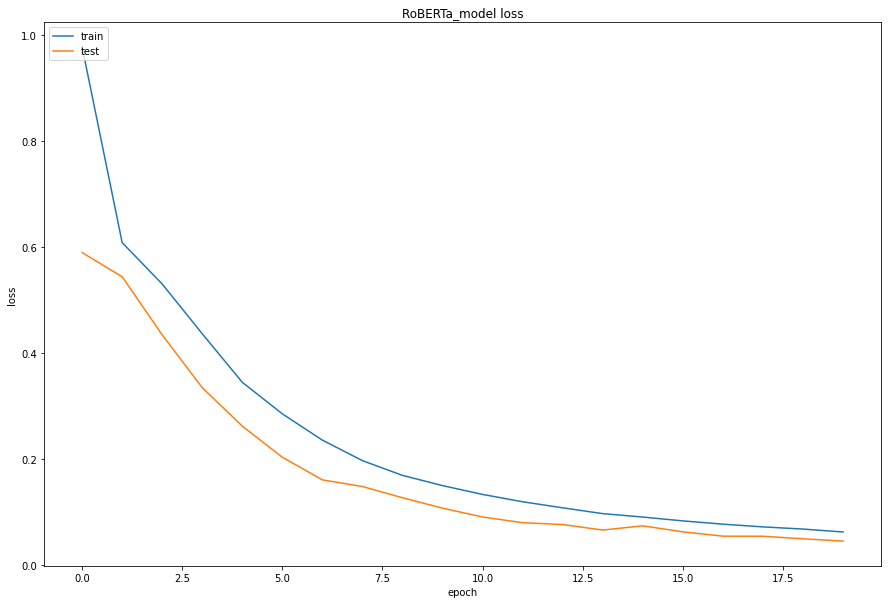

CPU times: user 166 ms, sys: 4.41 ms, total: 170 ms
Wall time: 173 ms


In [ ]:
#Plotting model loss
%%time
if TRAIN:
    # SUmmarizes history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('RoBERTa_model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
data_exists = True

In [ ]:
if data_exists:
    config = AutoConfig.from_pretrained('/content/my_tokenizer/config.json')
    backbone = TFAutoModel.from_config(config)

In [ ]:
if not TRAIN:
    model = build_model(data_exists, config)
    model.load_weights('/model.h5')
    


In [ ]:
model = build_model(data_exists, config)
model.load_weights('/model.h5')

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


##Predict

In [ ]:
from sklearn.utils import shuffle
samples = sequences.shape[0]
training_data = train.sample(frac=0.8, random_state=25)
testing_data = train.drop(training_data.index)

In [ ]:
print(test.head(5))
print(testing_data.head(5))
testing_data.drop(['annotation','location'], axis =1)

          id  case_num  pn_num  feature_num  \
0  00016_000         0      16            0   
1  00016_001         0      16            1   
2  00016_002         0      16            2   
3  00016_003         0      16            3   
4  00016_004         0      16            4   

                                          pn_history  \
0  HPI: 17yo M presents with palpitations. Patien...   
1  HPI: 17yo M presents with palpitations. Patien...   
2  HPI: 17yo M presents with palpitations. Patien...   
3  HPI: 17yo M presents with palpitations. Patien...   
4  HPI: 17yo M presents with palpitations. Patien...   

                                        feature_text  TARGET  
0  Family-history-of-MI-OR-Family-history-of-myoc...       0  
1                 Family-history-of-thyroid-disorder       1  
2                                     Chest-pressure       2  
3                              Intermittent-symptoms       3  
4                                        Lightheaded       4  
  

,id,case_num,pn_num,feature_num,pn_history,feature_text,TARGET
8,00224_000,0,224,0,"Pt is a 17 y/o M w/ episodic feeling of ""heart...",Family-history-of-MI-OR-Family-history-of-myoc...,0
14,00372_000,0,372,0,Pt is a 17 y/o male presenting with heart poun...,Family-history-of-MI-OR-Family-history-of-myoc...,0
23,00585_000,0,585,0,CC: 17 yo M c/o heart pounding\r\nHPI: Patient...,Family-history-of-MI-OR-Family-history-of-myoc...,0
25,00653_000,0,653,0,Dillon Cleveland is a 17yo male with a 3-4 mon...,Family-history-of-MI-OR-Family-history-of-myoc...,0
26,00669_000,0,669,0,17 y/o M complains of increased heart rate for...,Family-history-of-MI-OR-Family-history-of-myoc...,0
...,...,...,...,...,...,...,...
14282,94475_916,9,94475,916,HPI : Pt presents with headache with photopho...,Subjective-fever,142
14284,94592_916,9,94592,916,The patient is a 20 year old female who presen...,Subjective-fever,142
14287,94656_916,9,94656,916,Ms. Madden is a 20yo F who presents for 1 day ...,Subjective-fever,142
14293,95066_916,9,95066,916,20 yo f c/o bilateral Headache in all the head...,Subjective-fever,142


In [ ]:
test_sequences, test_masks, test_offsets = [], [],[]
row_ids = []
targets = []

for g1 in tqdm(testing_data.groupby('pn_num')):

    gdf = g1[1]
    pn_history  = gdf.iloc[0].pn_history
    targets.append([])
    row_ids.append([])
    
    test_tokens = tokenizer.encode_plus(pn_history, max_length=SEQUENCE_LENGTH, padding='max_length',truncation=True, return_offsets_mapping=True)
    test_sequence = test_tokens['input_ids']
    test_attention_mask = test_tokens['attention_mask'] 

    # BUILD THE TARGET ARRAY
    offset = test_tokens['offset_mapping']

    for index, row in gdf.iterrows():

        targets[-1].append(row.TARGET)
        row_ids[-1].append(row.id)
         
    test_sequences.append(test_sequence)
    test_masks.append(test_attention_mask)
    test_offsets.append(offset)

test_sequences = np.array(test_sequences).astype(np.int32)
test_masks = np.array(test_masks).astype(np.uint8)
targets_to_row_ids = [dict(zip(a,b)) for a,b in zip(targets,row_ids)]

  0%|          | 0/955 [00:00<?, ?it/s]

In [ ]:
# Builds the TensorFlow dataset with the embeddings arrays
test_dataset = tf.data.Dataset.from_tensor_slices(
        ((test_sequences, test_masks),)).batch(BATCH_SIZE).with_options(options)

In [ ]:
#Generate predictions
with strategy.scope():

    preds = model.predict(test_dataset,batch_size=BATCH_SIZE)

preds = np.argmax(preds, axis=-1)

80/80 [==============================] - 44s 496ms/step


In [ ]:
preds

array([[143, 143, 143, ..., 143, 143, 143],
       [143,  11,  11, ..., 143, 143, 143],
       [143, 143, 143, ..., 143, 143, 143],
       ...,
       [143, 127, 127, ..., 143, 143, 143],
       [143, 143, 143, ..., 143, 143, 143],
       [143, 143, 143, ..., 143, 143, 143]])

In [ ]:
#Inversing predictions to Locations
def decode_position(pos):

    return ";".join([" ".join(np.array(p).astype(str)) for p in pos])


def translate(preds,targets_to_row_ids,offsets):

    all_ids = []
    all_pos = []

    for k in range(len(preds)):

        offset = offsets[k]
        pred = preds[k]
        targets_to_ids = targets_to_row_ids[k]

        prediction = {targets_to_ids[t]:[] for t in targets_to_ids}
        i = 0

        while i<SEQUENCE_LENGTH:
            label = pred[i]
            
            if label == EMPTY_IDX:
                i += 1
                continue
            if label in targets_to_ids:
                key = targets_to_ids[label]
                start = offset[i][0]
                while i<SEQUENCE_LENGTH:
                    if pred[i] != label:
                        break
                    else:
                        end = max(offset[i])
                    i += 1
                if  end == 0:
                    break
                prediction[key].append((start, end))
            else:
                i+=1

        for key in prediction:
        
            all_ids.append(key)
            all_pos.append(decode_position(prediction[key]))

    df = pd.DataFrame({
        "id": all_ids,
        "pred_location": all_pos
    })
    return df

In [ ]:

sub = translate(preds, targets_to_row_ids, test_offsets)
sub.to_csv('submission.csv',index=False)
sub.head(50)

,id,pred_location
0,00016_005,
1,00016_011,5 9
2,00041_008,
3,00046_006,380 388;730 738
4,00046_007,573 576
5,00046_008,
6,00046_011,19 23
7,00082_010,61 75;187 209
8,00082_011,0 5
9,00100_002,310 324


In [ ]:
testing_data = testing_data.merge(train,on=['id'])#.merge(features,on=['location'])
testing_data = testing_data.merge(sub,on=['id'])#.merge(features,on=['location'])



In [ ]:
testing_data.to_csv('test1.csv')
testing_data.head(10)
# location_x or location_y refers to actual location while pred_location refers to predicted location

,id,case_num_x,pn_num_x,feature_num_x,annotation_x,location_x,pn_history_x,feature_text_x,TARGET_x,case_num_y,pn_num_y,feature_num_y,annotation_y,location_y,pn_history_y,feature_text_y,TARGET_y,pred_location
0,00224_000,0,224,0,['dad had recent MI'],['483 500'],"Pt is a 17 y/o M w/ episodic feeling of ""heart...",Family-history-of-MI-OR-Family-history-of-myoc...,0,0,224,0,['dad had recent MI'],['483 500'],"Pt is a 17 y/o M w/ episodic feeling of ""heart...",Family-history-of-MI-OR-Family-history-of-myoc...,0,483 500
1,00372_000,0,372,0,['dad MI'],['552 558'],Pt is a 17 y/o male presenting with heart poun...,Family-history-of-MI-OR-Family-history-of-myoc...,0,0,372,0,['dad MI'],['552 558'],Pt is a 17 y/o male presenting with heart poun...,Family-history-of-MI-OR-Family-history-of-myoc...,0,552 558
2,00585_000,0,585,0,['father had heart attack'],['490 513'],CC: 17 yo M c/o heart pounding\r\nHPI: Patient...,Family-history-of-MI-OR-Family-history-of-myoc...,0,0,585,0,['father had heart attack'],['490 513'],CC: 17 yo M c/o heart pounding\r\nHPI: Patient...,Family-history-of-MI-OR-Family-history-of-myoc...,0,490 513
3,00653_000,0,653,0,['Heart attack 1 year ago - father'],['917 949'],Dillon Cleveland is a 17yo male with a 3-4 mon...,Family-history-of-MI-OR-Family-history-of-myoc...,0,0,653,0,['Heart attack 1 year ago - father'],['917 949'],Dillon Cleveland is a 17yo male with a 3-4 mon...,Family-history-of-MI-OR-Family-history-of-myoc...,0,917 949
4,00669_000,0,669,0,['ather heart attack'],['765 783'],17 y/o M complains of increased heart rate for...,Family-history-of-MI-OR-Family-history-of-myoc...,0,0,669,0,['ather heart attack'],['765 783'],17 y/o M complains of increased heart rate for...,Family-history-of-MI-OR-Family-history-of-myoc...,0,764 783
5,00769_000,0,769,0,['MI at 52 for father'],['672 691'],Mr. Cole is a 17 m with c/o heart pounding. He...,Family-history-of-MI-OR-Family-history-of-myoc...,0,0,769,0,['MI at 52 for father'],['672 691'],Mr. Cole is a 17 m with c/o heart pounding. He...,Family-history-of-MI-OR-Family-history-of-myoc...,0,672 691
6,00831_000,0,831,0,['FATHER MI'],['556 562;567 569'],HPI- 17 YO M WITH C/O HEART PALPITATIONS FOR 3...,Family-history-of-MI-OR-Family-history-of-myoc...,0,0,831,0,['FATHER MI'],['556 562;567 569'],HPI- 17 YO M WITH C/O HEART PALPITATIONS FOR 3...,Family-history-of-MI-OR-Family-history-of-myoc...,0,556 569
7,00883_000,0,883,0,[],[],17yo male. presents with paroxysmal episodes o...,Family-history-of-MI-OR-Family-history-of-myoc...,0,0,883,0,[],[],17yo male. presents with paroxysmal episodes o...,Family-history-of-MI-OR-Family-history-of-myoc...,0,928 934
8,01010_000,0,1010,0,['MI in his father'],['732 748'],Dillon Cleveland is a 17 yo M who presents to ...,Family-history-of-MI-OR-Family-history-of-myoc...,0,0,1010,0,['MI in his father'],['732 748'],Dillon Cleveland is a 17 yo M who presents to ...,Family-history-of-MI-OR-Family-history-of-myoc...,0,716 748
9,01133_000,0,1133,0,['Dad had MI'],['592 602'],Mr. Cleveland is a 17 yo M presenting with epi...,Family-history-of-MI-OR-Family-history-of-myoc...,0,0,1133,0,['Dad had MI'],['592 602'],Mr. Cleveland is a 17 yo M presenting with epi...,Family-history-of-MI-OR-Family-history-of-myoc...,0,592 602


In [ ]:
def decode_location(locations):

    for x in ["[", "]", "'"]:
        locations = locations.replace(x,'')
    locations = locations.replace(',', ';')
    locations = locations.split(";")
    res = []
    for location in locations:
        if location:
            x, y = location.split()
            res.append((int(x), int(y)))
    return sorted(res, key=lambda x:x[0])
    

In [ ]:
# Used evaulation metrics from training. This is the custom function if we want to check the results manually
import statistics as st
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

def decode_location(locations):

    for x in ["[", "]", "'"]:
        locations = locations.replace(x,'')
    locations = locations.replace(',', ';')
    locations = locations.split(";")
    res = []
    for location in locations:
        if location:
            x, y = location.split()
            res.append((int(x), int(y)))
    return sorted(res, key=lambda x:x[0])

def f1(testing_data):


  f1_scores = []
  acc_scores = []
  precision_scores = []
  recall_scores = []
  for i in range(10): #testing_data.shape[0]-1):
    act_loc = [0] * 1000
    pred_loc = [0] * 1000 
    
    for start,end in decode_location(testing_data['location'][i]):
      for i in range(start,end):
        act_loc[i] = 1
    for start,end in decode_location(testing_data['pred_location'][i]):
      #pred_loc = pred_loc + ([i for i in range(start,end)])
      for i in range(start,end):
        pred_loc[i] = 1
    print(act_loc,pred_loc)
    f1_scores.append(f1_score(act_loc,pred_loc, average= 'micro'))
    acc_scores.append(accuracy_score(act_loc,pred_loc))
    precision_scores.append(precision_score(act_loc,pred_loc, average= 'micro'))
    recall_scores.append(recall_score(act_loc,pred_loc, average= 'micro'))

    print(f1_scores)
    


  f1_final = st.mean(f1_scores)
  accuracy_final = st.mean(acc_scores)
  precision_final = st.mean(precision_scores)
  recall_final = st.mean(recall_scores)

  return f1_final, accuracy_final, precision_final, recall_final

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##show paragraphs with with actual and predition locations highlighted

In [ ]:
import os
import spacy.displacy
import pandas as pd
import seaborn as sns
import json
import warnings
from IPython.core.display import display, HTML

In [ ]:
testing_data = pd.read_csv('test1.csv')

In [ ]:
annotation = testing_data["feature_text_x"]
ents = []
for i in range(204,205):
  spans = testing_data['pred_location'][i]
  label = testing_data['feature_text_x'][i]
  for start,end in decode_location(testing_data['pred_location'][i]):
      start_loc = start
      end_loc = end
      ents.append({
      'start': int(start_loc),
      'end': int(end_loc),
    'label': label
      })
  doc = {
  'text': testing_data['pn_history_x'][i],
  "ents": ents
    }
  p1 = sns.color_palette('hls', annotation.nunique(), desat=1).as_hex()
  p2 = sns.color_palette('hls', annotation.nunique(), desat=0.5).as_hex()
  colors = {k: f"linear-gradient(90deg, {c1}, {c2})" for k, c1, c2 in zip(annotation.unique(), p1, p2)}
  options = {"colors": colors}
  print('\033[1m' + 'Actual locations highlighted: ')
  spacy.displacy.render(doc, style="ent", options=options, manual=True, jupyter=True)
  print("\n\n")

  print('\033[1m' + 'Predicted locations highlighted: ')
  ents =[]
  for start,end in decode_location(testing_data['location_x'][i]):
      start_loc = start
      end_loc = end
      ents.append({
      'start': int(start_loc),
      'end': int(end_loc),
    'label': label
      })
  doc1 = {
  'text': testing_data['pn_history_x'][i],
  "ents": ents
    }
  p1 = sns.color_palette('hls', annotation.nunique(), desat=1).as_hex()
  p2 = sns.color_palette('hls', annotation.nunique(), desat=0.5).as_hex()
  colors = {k: f"linear-gradient(336deg, #e66465, #9198e5)" for k, c1, c2 in zip(annotation.unique(), p1, p2)}
  options = {"colors": colors}
  spacy.displacy.render(doc1, style="ent", options=options, manual=True, jupyter=True)

Actual locations highlighted: 





Predicted locations highlighted: 


In [ ]:
while(True):
  i=0
  i+=1